In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import time

# On importe la métrique "silhouette" qui nous servira à déterminer le nombre de clusters optimal.
from sklearn.metrics import silhouette_score 

%config InlineBackend.figure_format = 'png'

t = time.time()

In [2]:
df = pd.read_csv('data/df_train_prepro.csv')

In [3]:
len(df)

1610494

In [4]:
 df_clusters = df[['contextid','dayssincelastvisitdouble','campaignctrlast24h','nbdisplay_1hour','nbdayssincelastclick','display_size','ltf_nbpartnerdisplayssincelastclick','ltf_nbglobaldisplay_4w','ltf_nbpartnerclick_90d','ltf_nbpartnerdisplay_90d','ltf_nbpartnersales_90d','nbdisplayglobalapprox_1d_sum_xdevice','zonecostineuro']]

In [5]:
# On va chercher à obtenir des groupes d'observations de caractéristiques proches afin de voir si l'on peut distinguer les clics des non-clics. 
sc = StandardScaler()
Z = sc.fit_transform(df_clusters)
Z

array([[ 0.14873565, -0.40809959, -0.8906595 , ..., -0.01397608,
        -0.32103262, -0.25119805],
       [-1.92104218, -0.44867976, -0.360678  , ..., -0.01397608,
         0.8070464 , -0.36603538],
       [ 0.14873565, -0.33748309,  1.82717896, ..., -0.01397608,
        -0.5009203 , -0.27723314],
       ...,
       [ 0.97664678, -0.36785013, -0.92834265, ..., -0.01397608,
        -0.51352702,  1.57702331],
       [ 1.39060235, -0.4168148 ,  2.20278178, ..., -0.01397608,
        -0.34134216, -0.36790665],
       [ 0.14873565, -0.1664472 , -0.50158415, ..., -0.01397608,
        -0.45594838, -0.19116658]])

In [6]:
# Vérification que les moyennes sont nulles et les écarts-types unitaires. 
print(np.mean(Z, axis=0))
print(np.std(Z, axis=0, ddof=0))

[-4.69520271e-17  2.48472492e-16 -5.90496082e-17 -2.12479762e-17
 -9.95337090e-18  1.23711223e-17  1.66154232e-17 -1.56712648e-17
  9.90263342e-18  4.87962244e-18 -2.46683444e-18 -3.14228272e-16
 -1.21505246e-17]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [11]:
# On fixe une graine aléatoire pour avoir des résultats reproductibles
GRAINE = 127725252

In [12]:
%%time
# On va faire varier le nombre de clusters dans un intervalle réaliste, disons de 2 à 10.
range_clusters = np.arange(2, 11)
res = []
for k in range_clusters:
    kmeans = KMeans(n_clusters=k, random_state=GRAINE)
    kmeans.fit(Z)
    res.append(silhouette_score(Z, kmeans.labels_, n_jobs=-1, sample_size=25000, random_state=GRAINE))
    print(f"Nb clusters : {k} ; score silhouette : {res[-1]:.4f}.")
# print(res)

Nb clusters : 2 ; score silhouette : 0.8811.
Nb clusters : 3 ; score silhouette : 0.1483.
Nb clusters : 4 ; score silhouette : 0.2661.
Nb clusters : 5 ; score silhouette : 0.1818.
Nb clusters : 6 ; score silhouette : 0.2274.
Nb clusters : 7 ; score silhouette : 0.2001.
Nb clusters : 8 ; score silhouette : 0.2209.
Nb clusters : 9 ; score silhouette : 0.2383.
Nb clusters : 10 ; score silhouette : 0.2413.
Wall time: 10min 54s


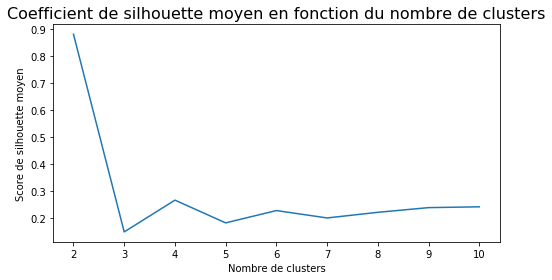

In [13]:
plt.figure(figsize=(8,4))
plt.plot(range_clusters, res)
plt.title("Coefficient de silhouette moyen en fonction du nombre de clusters", size=16)
plt.xlabel("Nombre de clusters", size=10)
plt.ylabel("Score de silhouette moyen", size=10)
plt.show()

In [14]:
%%time
# On applique la méthode des k-means sur les variables centrées et réduites, pour 2 clusters d'après la figure précédente.
kmeans = KMeans(n_clusters=2, random_state=GRAINE) 
# random_state est la graine aléatoire specifiée pour rendre les résultats reproductibles.
kmeans.fit(Z)

# On trie les index en fonction des différents groupes de députés (ie des clusters).
idk = np.argsort(kmeans.labels_)

# Affichage des observations et de leurs groupes.
print(pd.DataFrame({"Observation" : df_clusters.index[idk], "Cluster" : kmeans.labels_[idk]}))

         Observation  Cluster
0             628907        0
1            1002206        0
2             110984        0
3             518012        0
4              19419        0
5            1255889        0
6            1336647        0
7             855899        0
8             179692        0
9            1083992        0
10           1606400        0
11           1519851        0
12           1122600        0
13           1266207        0
14            509816        0
15            921110        0
16            417910        0
17            400871        0
18            509813        0
19            596558        0
20           1110022        0
21           1215186        0
22           1098962        0
23            210224        0
24             71491        0
25            233785        0
26           1171603        0
27            810876        0
28             56763        0
29            348987        0
...              ...      ...
1610464       537833        1
1610465   

In [15]:
nb_clusters = kmeans.labels_.tolist()
print(nb_clusters.count(0)) # Comptage du nombre d'observations dans le cluster 1.
print(nb_clusters.count(1)) # Comptage du nombre d'observations dans le cluster 2.

6055
1604439


Etudions les caractéristiques des observations dans chacun des clusters. 

In [16]:
A = pd.DataFrame({"Observation" : df_clusters.index[idk], "Cluster" : kmeans.labels_[idk]})
L1 = [] # Liste qui contiendra les index des observations du cluster 1.
L2 = [] # Liste qui contiendra les index des observations du cluster 2.
for i in range(len(A)) :
    if A['Cluster'][i] == 0 :
        L1.append(A['Observation'][i])
    if A['Cluster'][i] == 1 :
        L2.append(A['Observation'][i])

In [17]:
df_cluster_1 = df.loc[L1] # Sous-table avec les députés du cluster 1.
df_cluster_2 = df.loc[L2] # Sous-table avec les députés du cluster 2.

In [18]:
len(L1), len(L2)

(6055, 1604439)

On retrouve bien le nombre d'observations présentes dans chaque cluster. 

In [19]:
# Répartition des clics et des non clics dans le cluster 1.
display(pd.DataFrame({'Nb dans cluster 1' : df_cluster_1['is_display_clicked'].value_counts(), 'Prop dans cluster 1' : df_cluster_1['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 2.
display(pd.DataFrame({'Nb dans cluster 2' : df_cluster_2['is_display_clicked'].value_counts(), 'Prop dans cluster 2' : df_cluster_2['is_display_clicked'].value_counts(normalize=True)})) 

,Nb dans cluster 1,Prop dans cluster 1
0,5607,0.926012
1,448,0.073988


,Nb dans cluster 2,Prop dans cluster 2
0,1513135,0.943093
1,91304,0.056907


In [20]:
df_cluster_1.describe()

,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,googlepagevertical,...,nbdayssincelastclick,nbdisplay_1hour,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,is_display_clicked,zonecostineuro,display_size,hour
count,6055.000000,6055.000000,6038.000000,6038.000000,6038.000000,5.396000e+03,5.396000e+03,5.396000e+03,1867.000000,6038.0,...,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6055.000000,6.055000e+03,6055.000000
mean,7.368951,1.137242,34.020205,0.738158,69.220603,1.354934e+08,-8.991286e+07,-1.377201e+08,60.808249,-1.0,...,21.862758,7.045791,25.158943,31.096006,82.995013,0.306713,0.073988,1.566815,8.838023e+04,13.637325
std,1.844722,0.344131,32.858236,0.794530,560.887527,1.259570e+09,1.138407e+09,1.156366e+09,30.848273,0.0,...,30.757969,10.117579,21.039521,65.537452,100.569758,0.189205,0.261774,3.773516,9.737390e+04,5.197925
min,1.000000,1.000000,3.000000,0.000000,1.000000,-2.140960e+09,-2.146561e+09,-2.146412e+09,-1.000000,-1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.034118,0.000000,0.008475,0.000000e+00,0.000000
25%,6.000000,1.000000,4.000000,0.000000,12.000000,-9.001059e+08,-1.001938e+09,-1.089605e+09,41.000000,-1.0,...,3.000000,0.000000,6.900301,2.000000,28.000000,0.138873,0.000000,0.116908,1.600000e+04,9.000000
50%,8.000000,1.000000,14.000000,1.000000,16.000000,3.640997e+08,-6.162982e+07,-2.647673e+08,68.000000,-1.0,...,9.000000,3.000000,21.345833,10.179676,54.371852,0.245336,0.000000,0.470166,7.500000e+04,14.000000
75%,9.000000,1.000000,73.000000,1.000000,127.000000,1.384186e+09,7.314411e+08,6.607425e+08,86.000000,-1.0,...,29.000000,10.000000,41.000000,32.016319,98.894306,0.512220,0.000000,1.419523,1.536000e+05,18.000000
max,9.000000,2.000000,134.000000,2.000000,30724.000000,2.141561e+09,2.146829e+09,2.144924e+09,99.000000,-1.0,...,416.000000,65.000000,193.195278,1341.353333,1416.062778,0.790542,1.000000,84.459663,1.024000e+06,23.000000


In [21]:
df_cluster_2.describe()

,contextid,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,urlhash2,urlhash3,urlhash4,googleviewability,googlepagevertical,...,nbdayssincelastclick,nbdisplay_1hour,nbdisplaypartnerapprox_1d_sum_xdevice,nbdisplayaffiliateapprox_1d_sum_xdevice,nbdisplayglobalapprox_1d_sum_xdevice,valueperclick,is_display_clicked,zonecostineuro,display_size,hour
count,1.604439e+06,1.604439e+06,1.597545e+06,1.597545e+06,1.597545e+06,1.454150e+06,1.454150e+06,1.454150e+06,499790.000000,1597545.0,...,1.604439e+06,1.604439e+06,1.604439e+06,1.604439e+06,1.604439e+06,1.604439e+06,1.604439e+06,1.604439e+06,1.604439e+06,1.604439e+06
mean,5.634174e+00,1.104855e+00,3.663098e+01,7.278662e-01,9.465117e+01,9.932449e+07,-8.752985e+07,-1.201339e+08,59.246774,-1.0,...,2.039500e+01,4.898621e+00,1.437697e+01,1.778541e+01,4.426994e+01,2.619073e-01,5.690712e-02,1.109746e+00,8.250886e+04,1.388084e+01
std,2.415278e+00,3.063662e-01,3.344792e+01,8.059933e-01,9.919589e+02,1.254867e+09,1.153435e+09,1.171172e+09,31.070979,0.0,...,4.551058e+01,8.463495e+00,1.733520e+01,4.213287e+01,6.650557e+01,1.857042e-01,2.316651e-01,2.963097e+00,9.718140e+04,5.137991e+00
min,1.000000e+00,1.000000e+00,3.000000e+00,0.000000e+00,-1.000000e+00,-2.147479e+09,-2.147454e+09,-2.147479e+09,-1.000000,-1.0,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.411759e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.000000e+00,1.000000e+00,4.000000e+00,0.000000e+00,1.200000e+01,-9.531958e+08,-1.033737e+09,-1.044180e+09,36.000000,-1.0,...,0.000000e+00,0.000000e+00,1.584028e+00,2.393981e-01,8.000000e+00,1.142579e-01,0.000000e+00,7.100000e-02,4.000000e+00,1.000000e+01
50%,6.000000e+00,1.000000e+00,2.900000e+01,1.000000e+00,1.600000e+01,2.603107e+08,-6.162982e+07,-3.225585e+08,66.000000,-1.0,...,1.000000e+00,1.000000e+00,7.000000e+00,4.000000e+00,2.300000e+01,1.889853e-01,0.000000e+00,3.090000e-01,7.500000e+04,1.400000e+01
75%,7.000000e+00,1.000000e+00,7.300000e+01,1.000000e+00,1.270000e+02,1.384186e+09,7.889378e+08,7.657979e+08,85.000000,-1.0,...,1.700000e+01,6.000000e+00,2.150988e+01,1.677037e+01,5.445285e+01,5.000993e-01,0.000000e+00,9.600000e-01,1.080000e+05,1.800000e+01
max,9.000000e+00,2.000000e+00,1.340000e+02,2.000000e+00,3.177000e+04,2.147366e+09,2.147451e+09,2.147451e+09,100.000000,-1.0,...,1.062000e+03,1.610000e+02,4.602779e+02,2.269557e+03,3.953889e+03,7.905422e-01,1.000000e+00,1.000000e+02,1.101600e+06,2.300000e+01


On réessaye avec cette fois-ci 4 clusters.

In [22]:
%%time

kmeans1 = KMeans(n_clusters=4, random_state=GRAINE) 
kmeans1.fit(Z)
idk1 = np.argsort(kmeans1.labels_)
print(pd.DataFrame({"Observation" : df_clusters.index[idk1], "Cluster" : kmeans1.labels_[idk1]}))

         Observation  Cluster
0             360270        0
1            1441159        0
2             163248        0
3            1253291        0
4             163254        0
5             922975        0
6            1069618        0
7            1441144        0
8             344721        0
9             922986        0
10            344717        0
11            663506        0
12           1441132        0
13            663505        0
14            163273        0
15            922991        0
16           1253309        0
17            521879        0
18           1069603        0
19           1253313        0
20            163282        0
21           1441115        0
22           1253286        0
23           1441167        0
24            344737        0
25           1069631        0
26           1441200        0
27           1253269        0
28            163210        0
29            163211        0
...              ...      ...
1610464      1353772        3
1610465   

In [23]:
nb_clusters1 = kmeans1.labels_.tolist()
print(nb_clusters1.count(0)) 
print(nb_clusters1.count(1)) 
print(nb_clusters1.count(2))
print(nb_clusters1.count(3))

173642
1213295
6018
217539


In [24]:
B = pd.DataFrame({"Observation" : df_clusters.index[idk1], "Cluster" : kmeans1.labels_[idk1]})
T1 = [] 
T2 = [] 
T3 = []
T4 = []
for i in range(len(A)) :
    if B['Cluster'][i] == 0 :
        T1.append(B['Observation'][i])
    if B['Cluster'][i] == 1 :
        T2.append(B['Observation'][i])
    if B['Cluster'][i] == 2 :
        T3.append(B['Observation'][i])
    if B['Cluster'][i] == 3 :
        T4.append(B['Observation'][i])

In [25]:
df_clusters_1 = df.loc[T1] # Sous-table avec les députés du cluster 1.
df_clusters_2 = df.loc[T2]
df_clusters_3 = df.loc[T3]
df_clusters_4 = df.loc[T4]

In [26]:
len(T1), len(T2), len(T3), len(T4)

(173642, 1213295, 6018, 217539)

In [27]:
# Répartition des clics et des non clics dans le cluster 1.
display(pd.DataFrame({'Nb dans cluster 1' : df_clusters_1['is_display_clicked'].value_counts(), 'Prop dans cluster 1' : df_clusters_1['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 2.
display(pd.DataFrame({'Nb dans cluster 2' : df_clusters_2['is_display_clicked'].value_counts(), 'Prop dans cluster 2' : df_clusters_2['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 3.
display(pd.DataFrame({'Nb dans cluster 1' : df_clusters_3['is_display_clicked'].value_counts(), 'Prop dans cluster 1' : df_clusters_3['is_display_clicked'].value_counts(normalize=True)})) 
# Répartition des clics et des non clics dans le cluster 4.
display(pd.DataFrame({'Nb dans cluster 2' : df_clusters_4['is_display_clicked'].value_counts(), 'Prop dans cluster 2' : df_clusters_4['is_display_clicked'].value_counts(normalize=True)}))

,Nb dans cluster 1,Prop dans cluster 1
0,166912,0.961242
1,6730,0.038758


,Nb dans cluster 2,Prop dans cluster 2
0,1136065,0.936347
1,77230,0.063653


,Nb dans cluster 1,Prop dans cluster 1
0,5573,0.926055
1,445,0.073945


,Nb dans cluster 2,Prop dans cluster 2
0,210192,0.966227
1,7347,0.033773


In [23]:
print(f"Temps d'exécution total : {time.strftime('%H:%M:%S', time.gmtime(time.time()-t))}")

Temps d'exécution total : 00:08:10
